In [1]:
import sys
import pandas as pd
import numpy as np
import os
import datetime as DT
sys.path.append('..')
import rbf_functions

In [2]:
rbfs = [rbf_functions.original_rbf,
        rbf_functions.squared_exponential_rbf,
        rbf_functions.inverse_quadratic_rbf,
        rbf_functions.inverse_multiquadric_rbf,
        rbf_functions.exponential_rbf,
        rbf_functions.matern32_rbf,
        rbf_functions.matern52_rbf,
       ]

# Load model output for each activation function

In [3]:
# output_dir = f"../output/{rbf}/"

root_dir = "../output_smaller_eps"

nfearchive = {}
for n in rbfs:
    nfearchive[n.__name__] = {}

for entry in rbfs:
    name = entry.__name__
    output_dir = os.path.join(root_dir, name)
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
#             nfearchive[name][i.split("_")[0]] = pd.read_csv(output_dir + i)
            archives_by_nfe = pd.read_csv(os.path.join(output_dir, i))
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
#             selected_nfe = u_nfes[-1::]
            selected_nfe = u_nfes[0::10]
            selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe)]

# Transform the dataframe back into platypus solution instances, to have a collection of solutions for each generation

In [4]:
from platypus import Solution, Problem, Hypervolume

n_rbfs = 2
n_objs = 4
n_vars = n_rbfs * 3

problem = Problem(n_vars, n_objs)

# matters for hypervolume

problem.directions[0] = Problem.MINIMIZE  # MAX_P
problem.directions[1] = Problem.MAXIMIZE  # utility
problem.directions[2] = Problem.MAXIMIZE  # inertia
problem.directions[3] = Problem.MAXIMIZE  # reliability

archives = {}
seeds = np.arange(10, 101, 10).tolist()
for n in rbfs:
    archives[n.__name__] = {}
    for i in seeds:
        archives[n.__name__][i] = {}

for entry in rbfs:
    name = entry.__name__
    for s in nfearchive[name]: #nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns 
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive
        

# Load reference sets, turn into solutions sets

In [5]:
ref_dir = "./refsets/"
ref_sets = {}
for n in rbfs:
    name = n.__name__
    ref_sets[name] = {}
    data = pd.read_csv(f'{ref_dir}{name}_refset.csv')  
    ref_set = []
    for i, row in data.iterrows():
        solution = Solution(problem)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set

In [6]:
ref_sets.keys()

dict_keys(['original_rbf', 'squared_exponential_rbf', 'inverse_quadratic_rbf', 'inverse_multiquadric_rbf', 'exponential_rbf', 'matern32_rbf', 'matern52_rbf'])

# Or, load global reference set into solution set

In [7]:
ref_dir = "./ndoutput"
data = pd.read_csv(f'{ref_dir}/all_rbf_refset.csv')  
ref_set = []
for i, row in data.iterrows():
    solution = Solution(problem)
    solution.objectives = row
    ref_set.append(solution)

In [13]:


hv = Hypervolume(reference_set=ref_set)
a = pd.Series(dict(hypervolume=hv.calculate(ref_set)))
a.to_csv('./hv/hypervolume_global_refset.csv')

# Calculate Hypervolume for each seed

In [9]:


for entry in rbfs:
    rbf = entry.__name__

    tempnfe = {}
    temphv = {}
    nfe_sets = {}
    hv_sets = {}
    # for rbf in archives:
    nfe_sets[rbf] = {}
    hv_sets[rbf] = {}
    #hv = Hypervolume(reference_set=ref_sets[rbf])
    hv = Hypervolume(reference_set=ref_set) #global

    print(f"started {rbf} at {DT.datetime.now().strftime('%H:%M:%S')}")
    # seedl = [10, 20, 30]
    for seed in archives[rbf]:
        nfe_sets[rbf][seed] = {}
        hv_sets[rbf][seed] = {}
        s_archives = archives[rbf][seed]
        nfes = []
        hvs = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            hvs.append(hv.calculate(archive))
        nfe_sets[rbf][seed] = nfes
        hv_sets[rbf][seed] = hvs
        tempnfe[seed] = nfes
        temphv[seed] = hvs
        print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")
        
    dfhv = pd.DataFrame.from_dict(temphv, orient='index').T
    dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index').T
    dfhv.to_csv(f"./hv/{rbf}_hv_global.csv", index=False)
    dfnfe.to_csv(f"./hv/{rbf}_nfe.csv", index=False)
    #     dfhv.to_csv(f"hv_global/{rbf}_hv_all.csv", index=False) #global
    #     dfnfe.to_csv(f"hv_global/{rbf}_nfe_all.csv", index=False) #global


started original_rbf at 21:11:50
finished seed: 10 at 21:12:29
finished seed: 20 at 21:12:43
finished seed: 30 at 21:12:51
finished seed: 40 at 21:12:58
finished seed: 50 at 21:13:11
finished seed: 60 at 21:13:21
finished seed: 70 at 21:13:29
finished seed: 80 at 21:13:42
finished seed: 90 at 21:13:51
finished seed: 100 at 21:13:59
started squared_exponential_rbf at 21:13:59
finished seed: 10 at 21:14:09
finished seed: 20 at 21:14:16
finished seed: 30 at 21:14:25
finished seed: 40 at 21:14:32
finished seed: 50 at 21:14:47
finished seed: 60 at 21:14:58
finished seed: 70 at 21:15:07
finished seed: 80 at 21:15:14
finished seed: 90 at 21:15:20
finished seed: 100 at 21:15:40
started inverse_quadratic_rbf at 21:15:40
finished seed: 10 at 21:15:50
finished seed: 20 at 21:15:57
finished seed: 30 at 21:16:04
finished seed: 40 at 21:16:13
finished seed: 50 at 21:16:22
finished seed: 60 at 21:16:30
finished seed: 70 at 21:16:40
finished seed: 80 at 21:16:48
finished seed: 90 at 21:16:57
finished 

In [10]:
# import matplotlib.pyplot as plt
# rbf = 'original_rbf'

# fig, ax = plt.subplots(sharex=True)
# for i in nfe_sets:
#     ax.plot(nfe_sets_all[i], hv_sets_all[i])

# ax.set_xlabel('nfe')
# ax.set_ylabel('hypervolume')
# ax.set_title(rbf)
# sns.despine()

# plt.show()

# Plot Hypervolume (local reference set) 

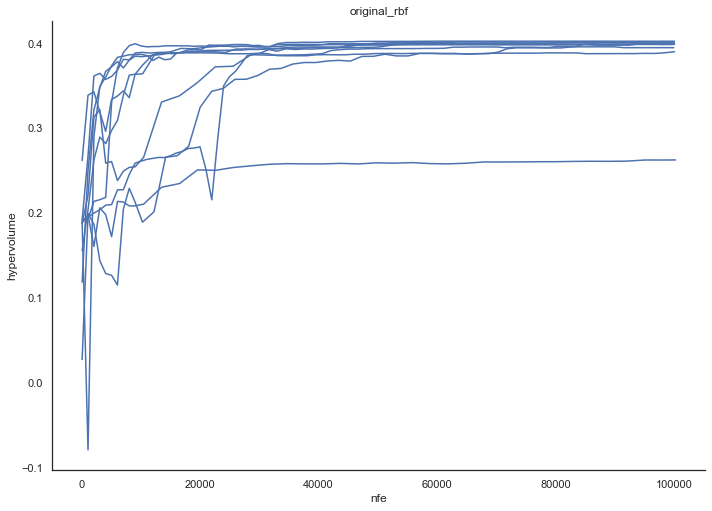

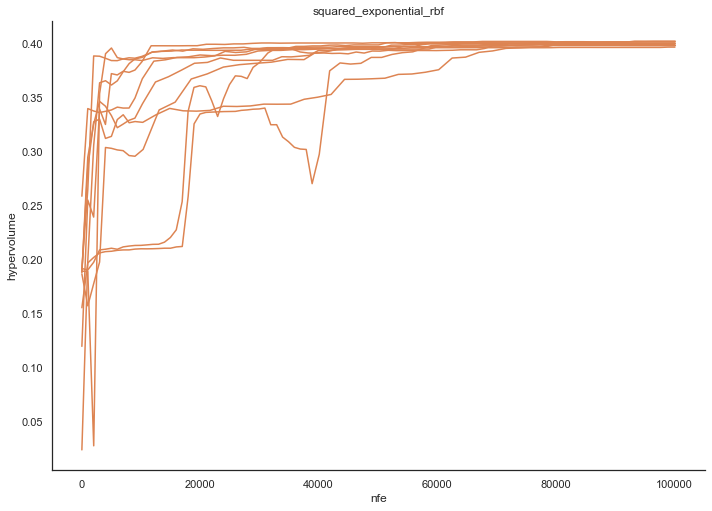

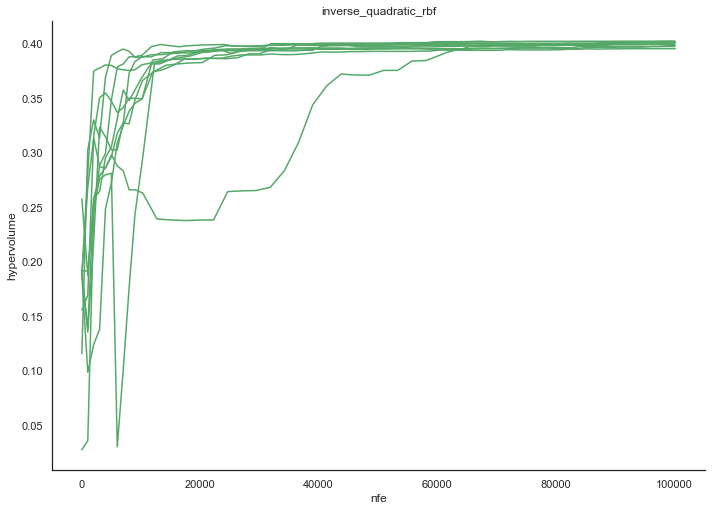

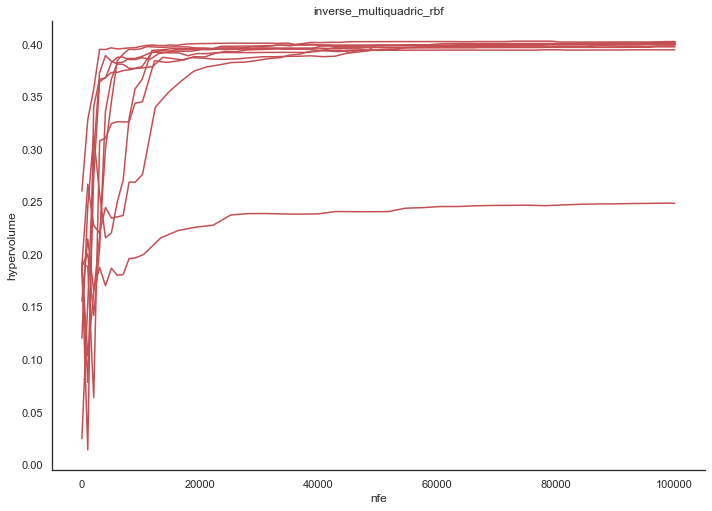

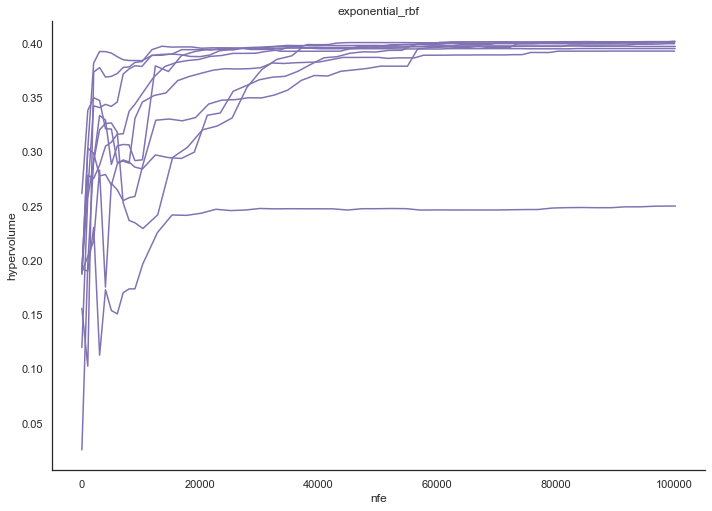

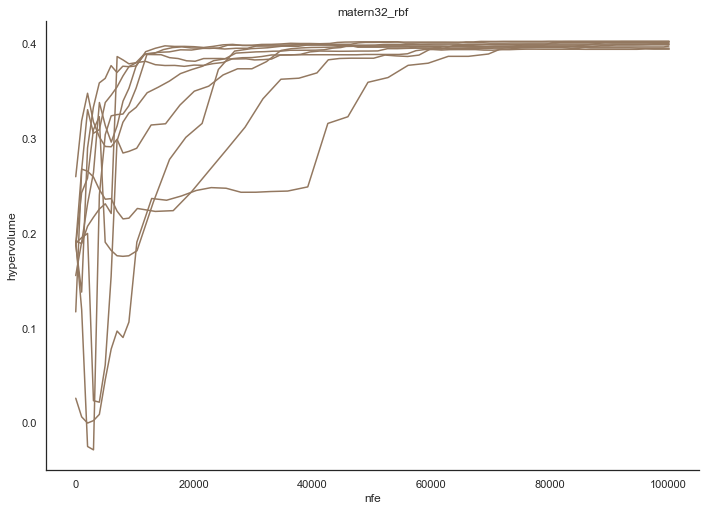

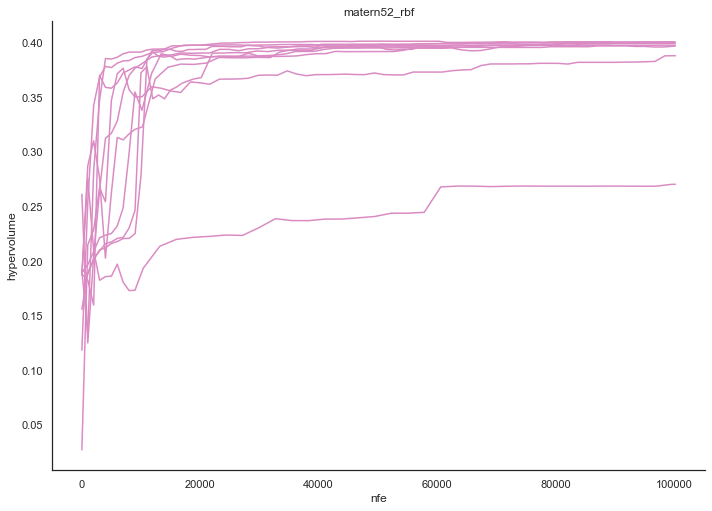

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

# Plot hypervolume for each rbf

for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    df_hv = pd.read_csv(f"./hv/{rbf}_hv_global.csv")
    df_hv_nfe = pd.read_csv(f"./hv/{rbf}_nfe.csv")
    fig, ax = plt.subplots(sharex=True)
    
    for i in range(len(df_hv_nfe.columns)):
        ax.plot(df_hv_nfe.iloc[:, i], df_hv.iloc[:, i], color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('hypervolume')
    ax.set_title(rbf)
    sns.despine()
plt.savefig(f'../figs/{rbf}/{rbf}_hv.jpg')
plt.savefig(f'../figs/{rbf}/{rbf}_hv.pdf')
plt.show()

# Plot Epsilon progress

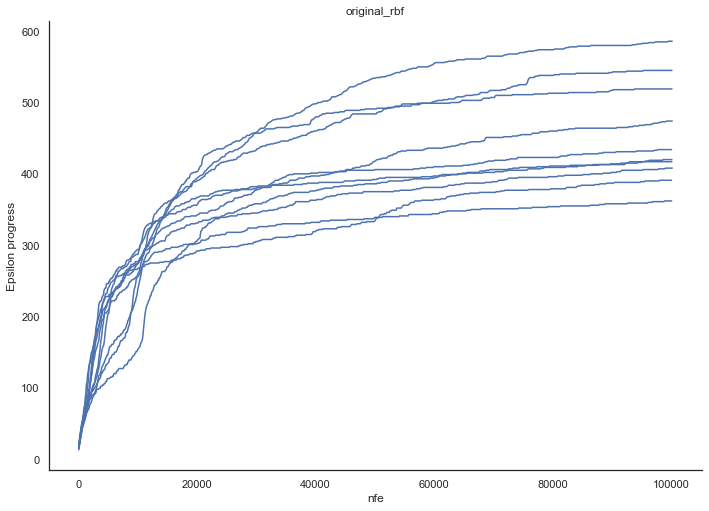

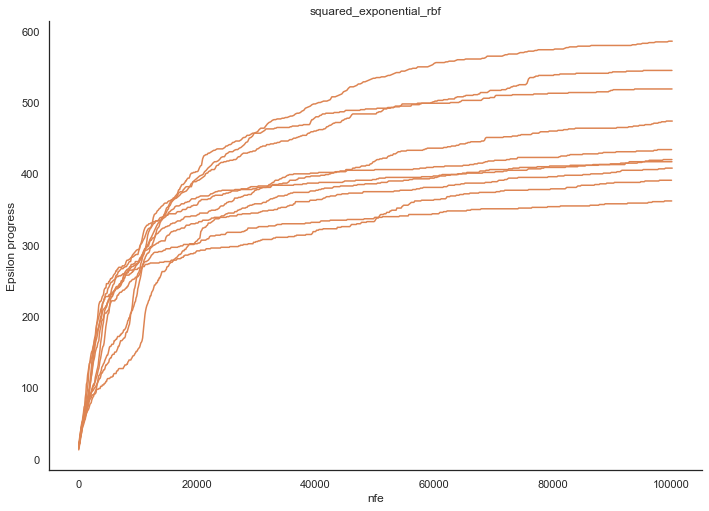

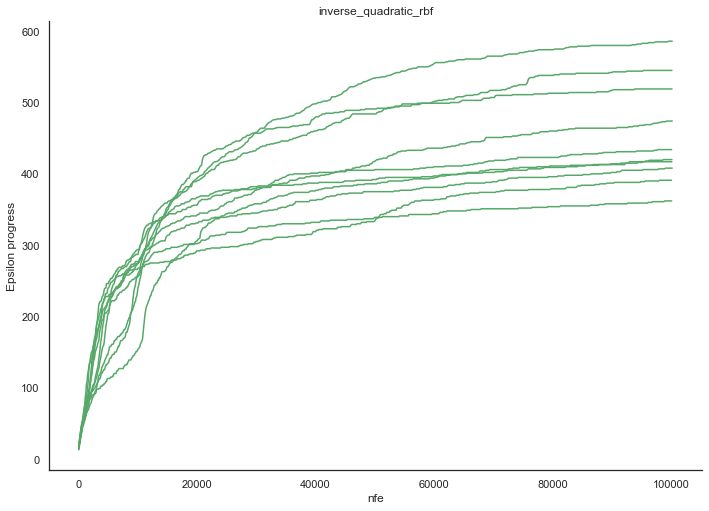

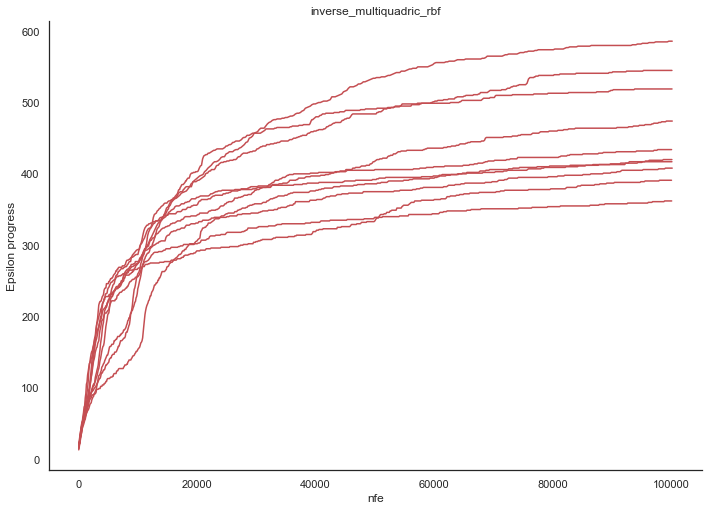

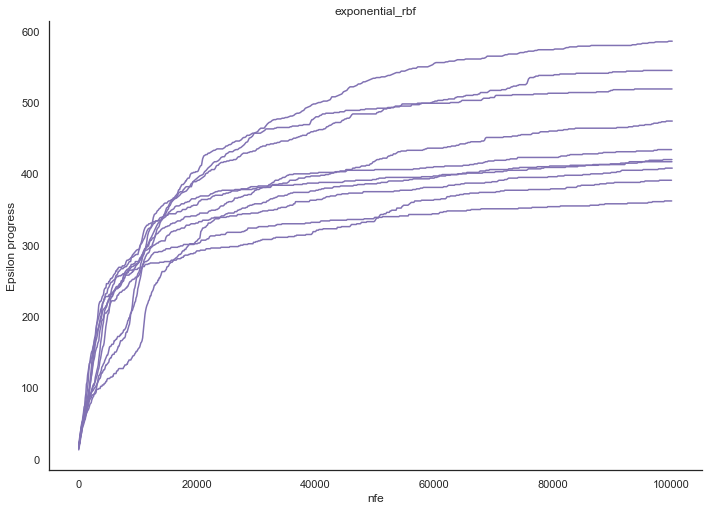

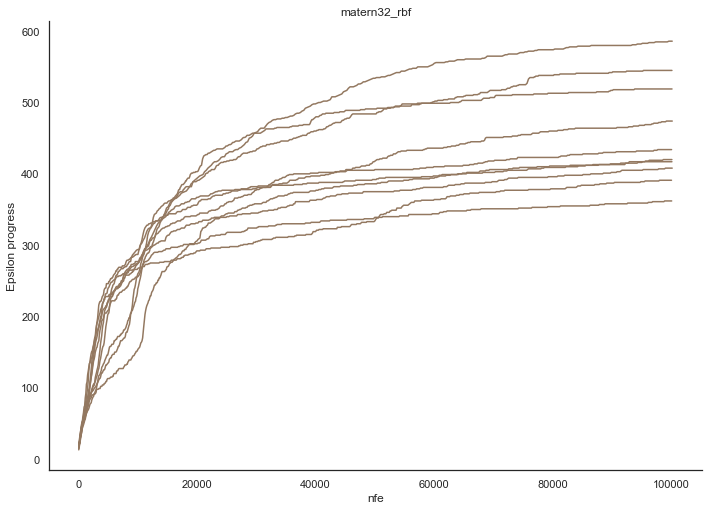

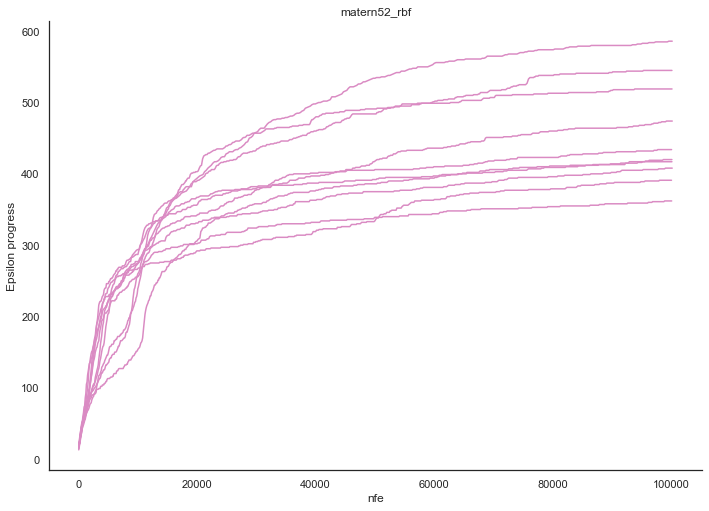

In [12]:
for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    
    ep_nfe = {}
    ep_improv = {}
    output_dir = os.path.join(root_dir, name)
    for i in os.listdir(output_dir):
        if i.endswith("_convergence.csv"):
            ep_load = pd.read_csv(os.path.join(output_dir, i))
            ep_nfe[int(i.split("_")[0])] = ep_load.nfe
            ep_improv[int(i.split("_")[0])]  = ep_load.improvements
    ep_nfe = pd.DataFrame.from_dict(ep_nfe)
    ep_improv = pd.DataFrame.from_dict(ep_improv)
    

    fig, ax = plt.subplots(sharex=True)
    for i in range(len(ep_nfe.columns)):
        ax.plot(ep_nfe.iloc[:, i], ep_improv.iloc[:, i], color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('Epsilon progress')
    ax.set_title(rbf)
    sns.despine()
    plt.savefig(f'../figs/{rbf}/{rbf}_epsprog.jpg')
    plt.savefig(f'../figs/{rbf}/{rbf}_epsprog.pdf')

plt.show()

# Plot Archive Size

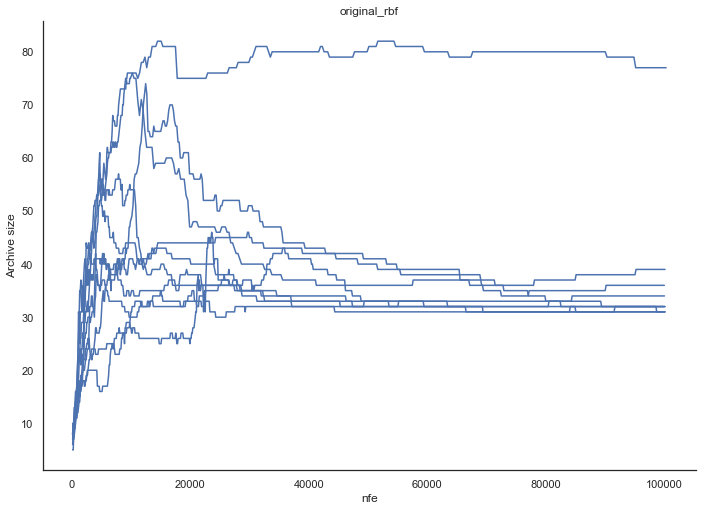

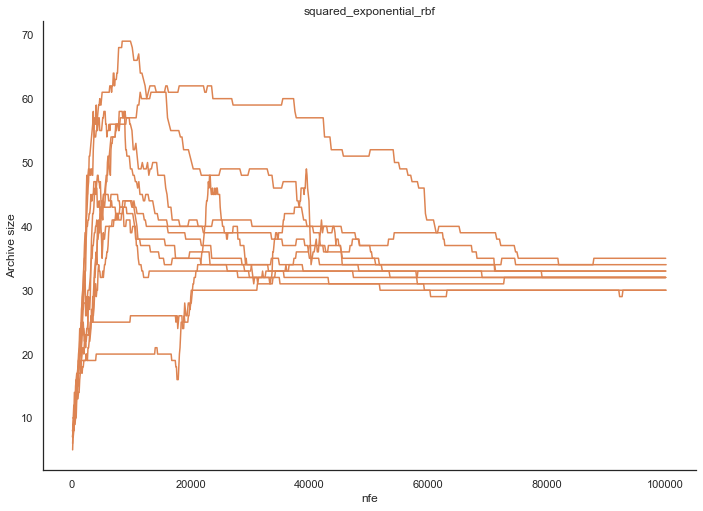

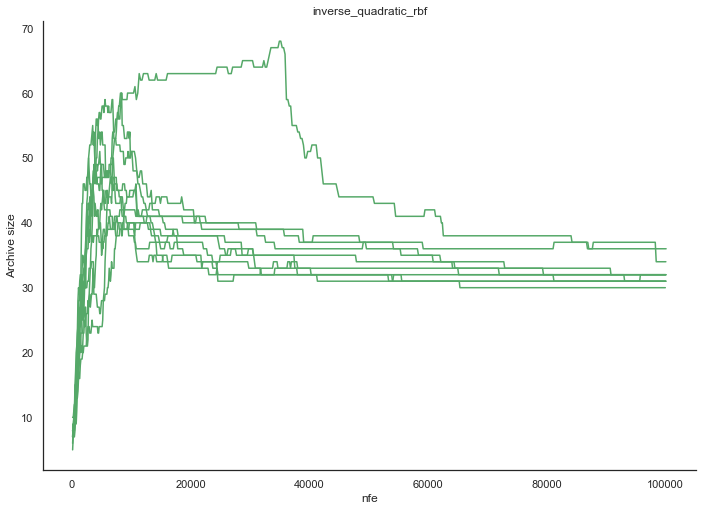

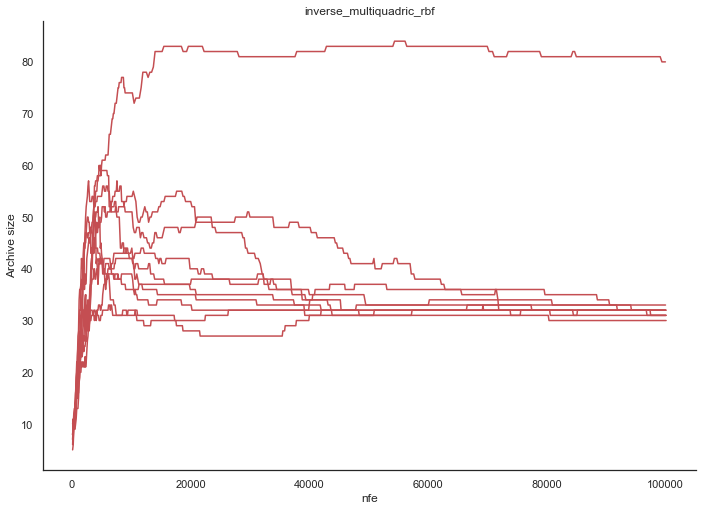

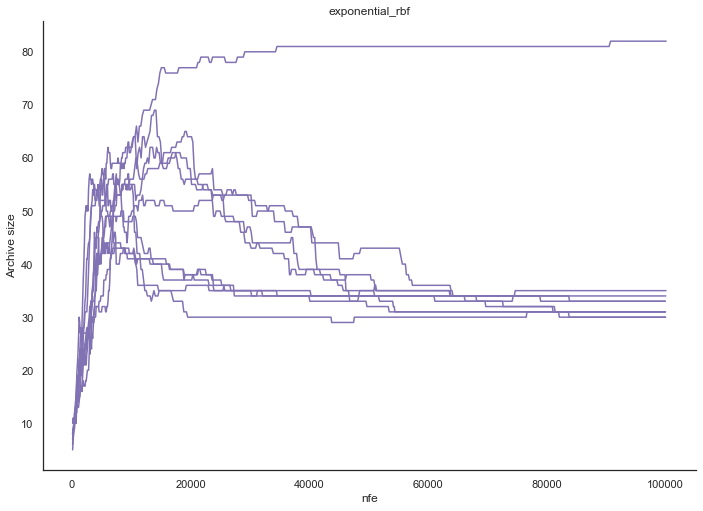

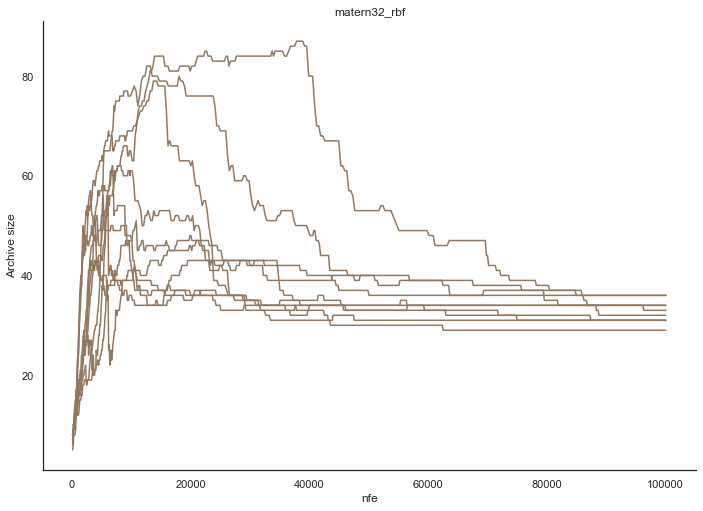

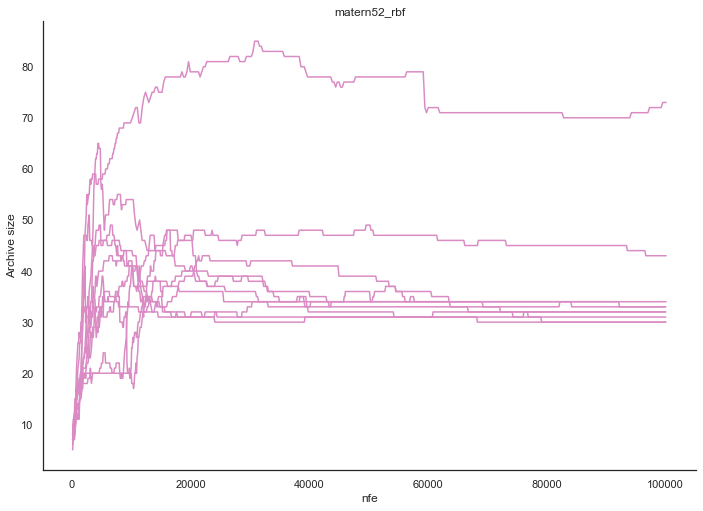

In [13]:
for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    archive_nfe = {}
    archive_count = {}
    output_dir = f"../output_smaller_eps/{rbf}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
            archives_by_nfe = pd.read_csv(output_dir + i)
            dups = archives_by_nfe.pivot_table(columns=["Unnamed: 0"], aggfunc='size')
            archive_nfe[int(i.split("_")[0])] = dups.index
            archive_count[int(i.split("_")[0])] = dups.reset_index(drop=True)

    archive_nfe = pd.DataFrame.from_dict(archive_nfe, orient='index').T
    archive_size = pd.DataFrame.from_dict(archive_count, orient='index').T
    
    fig, ax = plt.subplots(sharex=True)
    
    for i in range(len(archive_nfe.columns)):
        ax.plot(archive_nfe.iloc[:, i], archive_size.iloc[:, i], color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('Archive size')
    ax.set_title(rbf)
    sns.despine()
    plt.savefig(f'../figs/{rbf}/{rbf}_archsize.jpg')
    plt.savefig(f'../figs/{rbf}/{rbf}_archsize.pdf')
plt.show()

# Plot Hypervolume (global reference set) 

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set_style("white")

# # Plot hypervolume for each rbf

# for entry, c in zip(rbfs, sns.color_palette()):
#     rbf = entry.__name__
#     df_hv = pd.read_csv(f"hv_global/{rbf}_hv_all.csv")
#     df_hv_nfe = pd.read_csv(f"hv_global/{rbf}_hv_nfe_all.csv")
#     fig, ax = plt.subplots(sharex=True)

#     ax.plot(df_hv_nfe, df_hv, color=c)

#     ax.set_xlabel('nfe')
#     ax.set_ylabel('hypervolume')
#     ax.set_title(rbf)
#     sns.despine()
# #     plt.savefig(f'figs/{rbf}/{rbf}_hv_global.jpg')
# plt.show()